In [11]:
#!/usr/bin/env python
import time
import os
import io

from random import seed
from random import randint

from argparse import ArgumentParser, Namespace
import yaml
from multiprocessing import cpu_count

import matplotlib.pyplot as plt

# default is to maximize the objectives
import time as time
import copy
#get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy.stats import norm

# example of a gaussian process surrogate function
from math import sin
from math import pi
import numpy as np
from numpy import arange
from numpy import asarray
from numpy.random import normal
from numpy.random import uniform
from numpy.random import random
from numpy import cov
from numpy import mean
from numpy import std

from warnings import catch_warnings
from warnings import simplefilter


from autooed.utils.sampling import lhs
import random
#import xgboost as xgb
#from xgboost import XGBRegressor
#from xgboost import plot_tree
from sklearn import linear_model
from sklearn import ensemble
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, accuracy_score
#from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# loocv to manually evaluate the performance of a random forest classifier
from sklearn.model_selection import LeaveOneOut, cross_val_score

from scipy.stats import pearsonr as pearsonr
from scipy import ndimage, misc
import pickle
import re
#from rdkit import Chem
#from rdkit.Chem import AllChem
#from rdkit.Chem import Descriptors
#from chainer_chemistry.datasets.molnet import get_molnet_dataset
# the package is in the same directory
# get Today's date from python!
from datetime import datetime
from autooed.utils.sampling import lhs
from autooed.problem import build_problem
from autooed.mobo import build_algorithm
from autooed.utils.seed import set_seed
from autooed.utils.initialization import generate_random_initial_samples, load_provided_initial_samples
from autooed.utils.plot import plot_performance_space, plot_performance_metric
from autooed.utils.plot import plot_performance_space
from argparse import ArgumentParser, Namespace
from arguments import get_args
import matplotlib as mpl
from matplotlib import rc, rcParams

Text(0.5, 0, '!!!Ariaaaal')

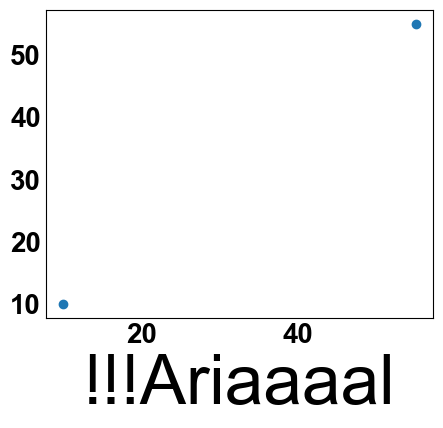

In [12]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [2]:
### Start the real optimization
# Change the default values for new argument
def get_general_args(args=None):
    '''
    General arguments: problem and algorithm description, experiment settings
    '''
    parser = ArgumentParser()

    parser.add_argument('--problem', type=str, default='contact_angle', 
        help='optimization problem')
    parser.add_argument('--algo', type=str, default='tsemo',
        help='type of algorithm to use with some predefined arguments, or custom arguments')
    parser.add_argument('--seed', type=int, default=10,
        help='the specific seed to run')
    parser.add_argument('--batch-size', type=int, default=1, 
        help='size of the batch in optimization')
    parser.add_argument('--n-init-sample', type=int, default=0, 
        help='number of initial design samples')
    parser.add_argument('--n-total-sample', type=int, default=8, 
        help='number of total design samples (budget)')

    args, _ = parser.parse_known_args(args)
    return args


def get_surroagte_args(args=None):
    '''
    Arguments for fitting the surrogate model
    '''
    parser = ArgumentParser()

    parser.add_argument('--surrogate', type=str, 
        choices=['gp', 'nn', 'bnn'], default='gp', 
        help='type of the surrogate model')

    args, _ = parser.parse_known_args(args)
    return args


def get_acquisition_args(args=None):
    '''
    Arguments for acquisition function
    '''
    parser = ArgumentParser()

    parser.add_argument('--acquisition', type=str,  
        choices=['identity', 'pi', 'ei', 'ucb', 'ts'], default='ei', 
        help='type of the acquisition function')

    args, _ = parser.parse_known_args(args)
    return args


def get_solver_args(args=None):
    '''
    Arguments for multi-objective solver
    '''
    parser = ArgumentParser()

    # general solver
    parser.add_argument('--solver', type=str, 
        choices=['nsga2', 'moead', 'parego', 'discovery', 'ga', 'cmaes'], default='nsga2', 
        help='type of the multiobjective solver')
    parser.add_argument('--n-process', type=int, default=2,
        help='number of processes to be used for parallelization')

    args, _ = parser.parse_known_args(args)
    return args


def get_selection_args(args=None):
    '''
    Arguments for sample selection
    '''
    parser = ArgumentParser()

    parser.add_argument('--selection', type=str,
        choices=['direct', 'hvi', 'random', 'uncertainty'], default='hvi', 
        help='type of selection method for new batch')

    args, _ = parser.parse_known_args(args)
    return args

def get_args():
    '''
    Get arguments from all components
    You can specify args-path argument to directly load arguments from specified yaml file
    '''
    parser = ArgumentParser()
    parser.add_argument('--args-path', type=str, default=None,
        help='used for directly loading arguments from path of argument file')
    args, _ = parser.parse_known_args()

    if args.args_path is None:

        general_args = get_general_args()
        surroagte_args = get_surroagte_args()
        acquisition_args = get_acquisition_args()
        solver_args = get_solver_args()
        selection_args = get_selection_args()

        module_cfg = {
            'surrogate': vars(surroagte_args),
            'acquisition': vars(acquisition_args),
            'solver': vars(solver_args),
            'selection': vars(selection_args),
        }

    else:
        
        with open(args.args_path, 'r') as f:
            all_args = yaml.load(f)
        
        general_args = Namespace(**all_args['general'])
        module_cfg = all_args.copy()
        module_cfg.pop('general')

    return general_args, module_cfg

In [3]:
# load arguments
args, module_cfg = get_args()
print (args.seed)
# set random seed
set_seed(args.seed)

# build problem
problem = build_problem(args.problem)
print(problem)

# build algorithm
algorithm = build_algorithm(args.algo, problem, module_cfg)
print(algorithm)

# read the initial samples, X is 2 Ratios, Y is two objective: 
# Strength, Toughness.
path = ['./Keegan_20230426_X.csv', 
        './Keegan_20230426_Y.csv']
X, Y = load_provided_initial_samples(path)
# we minimze the Objectives, so multiply -1
Y = Y.reshape(5, 1)
Y = -Y
print ('read X', X.shape)
print ('read Y', Y.shape)

X0 = X
Y0 = Y
# optimization
while len(X) < args.n_total_sample:
    start = time.time()
    # propose design samples
    X_next = algorithm.optimize(X, Y, X_busy=None, batch_size=1)
    print (X_next)
    print (time.time() - start)
    # evaluate proposed samples
    Y_next = np.array([problem.evaluate_objective(x) for x in X_next])
    # combine into dataset
    X = np.vstack([X, X_next])
    Y = np.vstack([Y, Y_next])
    for (x_next, y_next) in zip(X_next, Y_next):
        new_sample = []
        new_sample.append(y_next[0])
        new_sample = str(new_sample)
        new_sample = new_sample.replace("[", "")
        new_sample = new_sample.replace("]", "")
        new_sample = new_sample + "\n"
        with open('new_evaluated.csv','a') as fd:
                fd.write(new_sample)        
    print(f'{len(X)}/{args.n_total_sample} complete')
    print (time.time() - start)

10
========== Problem Definition ==========
# name: contact_angle
# n_var: 4
# n_obj: 1
# n_constr: 0

========== Algorithm Setup ==========
# algorithm: TSEMO
# surrogate: GaussianProcess
# acquisition: ThompsonSampling
# solver: NSGA2
# selection: HypervolumeImprovement

read X (5, 4)
read Y (5, 1)


/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 0.0024787521766663585. Decreasing the bound and calling fit again may find 

[[  7   0 100 100]]
17.991440773010254
6/8 complete
21.406864881515503


/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 0.0024787521766663585. Decreasing the bound and calling fit again may find 

[[ 1 73  6 15]]
18.341817617416382
7/8 complete
49.75660181045532


/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 0.0024787521766663585. Decreasing the bound and calling fit again may find 

[[ 0 38 23  0]]
19.14143180847168
8/8 complete
25.23579239845276


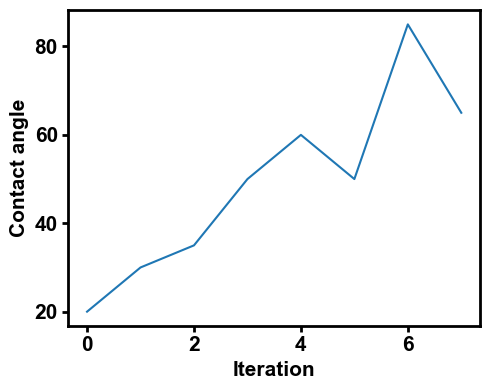

In [28]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.plot (np.arange(len(Y)), -Y)
ax.tick_params(axis='both', length=4, width=2, colors='black', grid_alpha=0, labelsize=15)
[i.set_linewidth(2) for i in ax.spines.values()]
plt.xlabel('Iteration', fontname='Arial', fontweight = 'bold', fontsize=15)
plt.ylabel('Contact angle', fontname='Arial', fontweight = 'bold', fontsize=15)

plt.tight_layout()
plt.savefig('cont_ang_iteration.jpeg', dpi=500)